# real_shape_optimization

> Fix isogonal modes and get real space vertices by minimizing metric energy under (soft?) tension constraint.

Unfortunately, our shape-based energy turns out to be quite _brittle_ and prone to issues like self-intersection etc

# to do:

- check for errors by writing a function that checks polygon intersection: is any point in any other polygon? use half-space check to do this. also function for self-intersection. see https://stackoverflow.com/questions/471962/how-do-i-efficiently-determine-if-a-polygon-is-convex-non-convex-or-complex/45372025#45372025

- wrap up the simulation time iteration with additional functions. clean up the energy function to make it more modular (i.e. enable switching out the function which calculates energy for each face).

- plotting function to color cells, or triangles by `dict`

In [ ]:
#| default_exp isogonal

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *
from CE_simulation.delaunay import *

In [ ]:
#| export
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize

from tqdm.notebook import tqdm

from math import floor, ceil

import sys

from copy import deepcopy

from collections import Counter

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import ipywidgets as widgets
from matplotlib import animation, rc
rc('animation', html='html5')

In [ ]:
#| export

import autograd.numpy as anp  # Thinly-wrapped numpy
from autograd import grad as agrad

In [ ]:
#| notest

# reimport stuff if required after updating the code elsewhere

import importlib

## this is how you re-import a module
#importlib.reload(nameOfModule)

## this is how you reload a specific function or class
#import X
#reload(X)
#from X import Y  # or * for that matter

## matplotlib slider plots

Structure: create a _callback function_ which does the plotting you want, depending on parameter. Then use generator, e.g. `widgets.interact` with a slider for each argument, to create user interfaces.

For optimization, one can rewrite the callback function to do as little as possible, e.g. by re-using the figure created. Ignore for now...

Plotting different times can be done easily this way by passing index to data array as callback argument


https://notebook.community/seewhydee/ntuphys_nb/jupyter_tutorial/jupyter_tutorial_02

Other slides types exist also, eg. `IntSlider`, or `ToggleButton`. See https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html. You can also write a somewhat optimized function, where minimal amount of work is done in the callback function, and the figure is only created once.

#### Animation

we can also done HMTL5 animations in place. This is nice, I don't have to jump to terminal to render with fffmpeg.

## Definition of the cell shape tensor, and vertex model energy

Now based off of the sides

In [ ]:
#| export

@patch
def get_shape_tensor(self: Face):
    neighbors = [he.twin.face for he in self.hes]
    if (None in neighbors) or self is None:
        return np.eye(2)
    edges = np.stack([x.dual_coords-self.dual_coords for x in neighbors])
    lengths = np.linalg.norm(edges, axis=-1)
    return 2*np.einsum('ei,ej->ij', edges, (edges.T/(lengths.T+1e-3)).T)

@patch
def set_rest_shapes(self: HalfEdgeMesh):
    """ill defined for boundary faces."""
    for fc in self.faces.values():
        if fc is not None:
            fc.rest_shape = fc.get_shape_tensor()

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)
mesh.set_voronoi()
mesh.faces[1].get_shape_tensor(), sqrt(3)

(array([[1.72905599e+00, 5.55111512e-17],
        [1.66533454e-16, 1.72905599e+00]]),
 1.7320508075688772)

In [ ]:
#| export

def polygon_area(pts):
    """area of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return anp.sum(pts[:,0]*anp.roll(pts[:,1], 1, axis=0) - anp.roll(pts[:,0], 1, axis=0)*pts[:,1], axis=0)/2

def polygon_perimeter(pts):
    """perimeter of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return anp.sum(anp.linalg.norm(pts-anp.roll(pts, 1, axis=0), axis=1))

def get_vertex_energy(pts, A0=1, P0=1, mod_shear=0, mod_bulk=1):
    """Get vertex style energy"""
    return mod_bulk*(polygon_area(pts)-A0)**2 + mod_shear*(polygon_perimeter(pts)-P0)**2

@patch
def get_area(self: Vertex):
    neighbors = [fc for fc in self.get_face_neighbors()]
    if None in neighbors:
        return None
    return polygon_area(np.stack([fc.dual_coords for fc in neighbors]))

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)
mesh.set_voronoi()
mesh.vertices[14].get_area()

0.8660254037844386

In [ ]:
poly = np.array([[-0.45, -0.31],
           [-0.54,  0.36],
           [ 0.09,  0.61],
           [ 0.54,  0.22],
           [ 0.51, -0.37],
           [ 0.07, -0.61]])

poly_repeat = poly = np.array([[-0.45, -0.31],
           [-0.54,  0.36],
           [ 0.09,  0.61],
           [ 0.54,  0.22],
           [ 0.51, -0.37],
           [ 0.07, -0.61], [ 0.07, -0.61], [ 0.07, -0.61]])


In [ ]:
poly_stacked = np.stack(50*[poly_repeat], axis=-1)

In [ ]:
polygon_area(poly_stacked)

array([0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471, 0.9471,
       0.9471, 0.9471])

In [ ]:
polygon_area(poly), polygon_area(poly_repeat)

(0.9471, 0.9471)

## Code for primal energy minimization

Need to ``serialize'' half edge mesh for rapid optimization

In [ ]:
#| export

@patch
def dual_vertices_to_initial_cond(self: HalfEdgeMesh):
    """Format dual vertices for use in energy minimization."""
    face_keys = sorted(self.faces.keys())
    dual_vertex_vector = np.stack([self.faces[key].dual_coords for key in face_keys]).T
    return np.hstack([dual_vertex_vector[0], dual_vertex_vector[1]])
       
@patch
def initial_cond_to_dual_vertices(self: HalfEdgeMesh, x0):
    """Reverse of format dual vertices for use in energy minimization."""
    face_keys = sorted(self.faces.keys())
    x, y = (x0[:int(len(x0)/2)], x0[int(len(x0)/2):])
    dual_vertex_vector = np.stack([x, y], axis=1)
    return {key: val for key, val in zip(face_keys, dual_vertex_vector)}


### Angle constraint energy

In [ ]:
#| export

@patch
def get_angle_deviation(self: HalfEdgeMesh):
    """Angle between primal and dual edges. For diagnostics"""
    angle_deviation = {}

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None):
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            primal_edge = he.face.dual_coords - he.twin.face.dual_coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = primal_edge / np.linalg.norm(primal_edge)        
            angle_deviation[he._heid] = np.dot(dual_edge, primal_edge)**2
    return angle_deviation

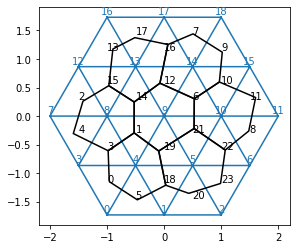

In [ ]:
# iterate over edges and ensure angle primal | dual = 0

mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.set_centroid()
mesh.set_rest_lengths() 
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.05))

mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=True)

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
sum(mesh.get_angle_deviation().values()) / 2

0.5464942990980662

## Energy function

In [ ]:
#| export

@patch
def get_primal_energy_fct_vertices(self: HalfEdgeMesh, mod_bulk=1, mod_shear=.01, angle_penalty=100,
                                   reg_bulk=0, A0=sqrt(3)/2,  max_valence=10,):
    """Get function to compute primal energy from primal vertices."""

    # stuff for the shape tensor energy
    face_list = []    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    face_key_dict[None] = None
    rest_shapes = []
    for fc in self.faces.values():
        neighbors = [he.twin.face for he in fc.hes]
        if not (None in neighbors):
            face_list.append(anp.array([face_key_dict[x._fid] for x in neighbors]
                                      +[face_key_dict[fc._fid]]))
            rest_shapes.append(fc.rest_shape)
    face_list = anp.array(face_list).T
    rest_shapes = anp.stack(rest_shapes)
    n_faces = len(self.faces)

    # stuff for the vertex-energy-based regularization
    cell_list = []
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            cell = [face_key_dict[fc._fid] for fc in neighbors]
            try:
                cell = anp.pad(cell, (0, max_valence-len(cell)), mode="edge")
            except ValueError:
                print(f"celll with more than {max_valence} nghbs, increase max_valence")
            cell_list.append(cell)
    cell_list = anp.array(cell_list)
    
    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]]
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = anp.array(e_dual)
    e_lst_primal = anp.array(e_lst_primal)
    
    # breaking translational invariance.
    center = anp.mean([v.coords for v in self.vertices.values()], axis=0)
    
    def get_E(x0):
        x, y = (x0[:n_faces], x0[n_faces:])
        pts = anp.stack([x, y], axis=-1)
        # shape energy - can be either vertex style or shape tensor based
        edges = anp.stack([pts[a]-pts[face_list[3]] for a in face_list[:3]])
        lengths = anp.linalg.norm(edges, axis=-1) + 1e-2
        units = (edges.T/lengths.T).T        
        tensors = 2*anp.einsum('efi,efj->fij', edges, units) - rest_shapes
        E_shape = (mod_shear*4*anp.mean(tensors**2)
                   + mod_bulk*anp.mean((tensors[:,0,0]+tensors[:,1,1])**2)) # sum
        # regularize with the vertex model energy
        poly = anp.stack([[x[i], y[i]] for i in cell_list.T]) # shape (max_valence, 2, n_cells)
        E_vertex = reg_bulk*anp.mean((polygon_area(poly)-A0)**2)
        # angle penalty
        e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]]
        e_primal = (e_primal.T/anp.linalg.norm(e_primal, axis=-1)).T
        E_angle = angle_penalty * anp.mean(anp.einsum('ei,ei->e', e_primal, e_dual)**2)
        # break translation symmetry
        E_trans = 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
        
        return  E_angle + E_shape + E_vertex + E_trans
    
    return get_E, agrad(get_E)

## Minimization, angle constrained 

Big speed improvement obtained by vectorizing the cell-area vertex model term. Optimization works best with method BFGS, can put a cap on max iterations. Sometimes, optimizer complains about precision loss but that seems to be ok.

Creation of the energy function and re-setting of positions is pretty fast, 10ms each approx for 13*9 mesh.

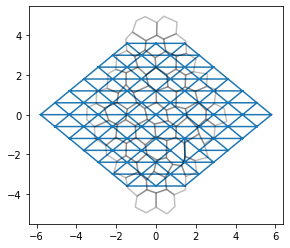

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=13, nx=9)

mesh.flip_edge(151)  # this creates an example of an edge with != 6 sides. e.g. 9
mesh.set_centroid()
mesh.set_rest_lengths()
mesh.set_rest_shapes() 

mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.06)) #shear_mat(1.2)@x)
mesh.transform_vertices(shear_mat(1.45)) # 1.31almost 90 degree angles

mesh.cellplot(alpha=.25)
mesh.triplot()
#mesh.labelplot()

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
mod_bulk = 1
mod_shear = .1
angle_penalty = 10

A0 = sqrt(3)/2
reg_bulk = 0.05

cell_shape_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear, "angle_penalty": angle_penalty,
                   "A0": A0, "reg_bulk": reg_bulk}

In [ ]:
x0 = mesh.dual_vertices_to_initial_cond()
get_E, jac = mesh.get_primal_energy_fct_vertices(**cell_shape_args)

In [ ]:
%%time
sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", tol=5*1e-2,
                        options={"maxiter": 500})
#print(sol["message"])
print(get_E(x0)/get_E(sol["x"]))

# tol = 1e-1 -> energy =.25, .8s. this is not good enough!
# tol = 5*1e-2 -> energy =.05, 3s with maxiter 250
# might be better to set max iter. to around 200

12.464660188256536
CPU times: user 91.2 ms, sys: 38.8 ms, total: 130 ms
Wall time: 43.8 ms


In [ ]:
new_coord_dict = mesh.initial_cond_to_dual_vertices(sol["x"])
for key, val in mesh.faces.items():
    val.dual_coords = new_coord_dict[key]

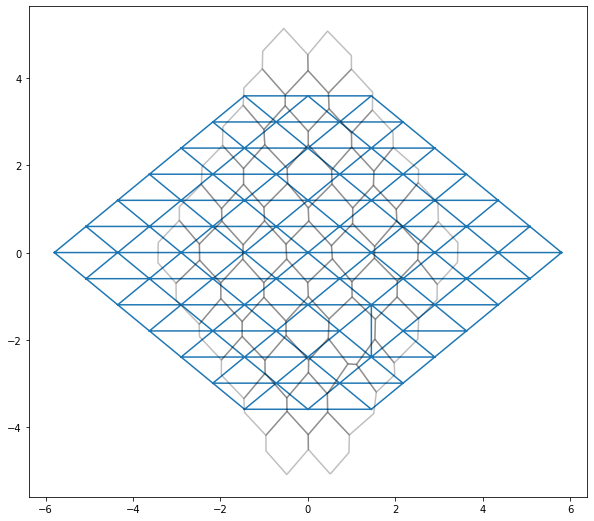

In [ ]:
# completely correct - but can have problem at boundary if there was an edge flip!
# in this case, ever self-intersection can occur.

# actuall;y it already does here!

fig = plt.figure(figsize=(10, 10))

mesh.cellplot(alpha=.25)
mesh.triplot()
#mesh.labelplot() # halfedge_labels=True

#pts = np.stack([fc.dual_coords for fc in mesh.vertices[10].get_face_neighbors()])
#plt.scatter(*pts.T, c="r")

plt.gca().set_aspect("equal", adjustable="box");

### We will need to compute primal lengths to flip edges

Might use the same technique as above to get the line orientation right (i.e. check whether parallel or anti-parallel with the centroid connector), which might be better numerically.

Indexed by `_heid`

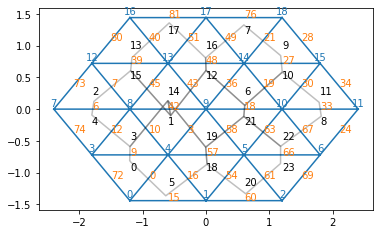

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.set_rest_lengths() 
mesh.transform_vertices(shear_mat(1.2)) # 1.31almost 90 degree angles
mesh.set_voronoi()
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.02))

# create self-intersection
mesh.faces[14].dual_coords, mesh.faces[1].dual_coords = (mesh.faces[1].dual_coords, mesh.faces[14].dual_coords)


mesh.cellplot(alpha=.25)
mesh.triplot()
mesh.labelplot(halfedge_labels=True)

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
#| export

@patch
def get_primal_edge_lens(self: HalfEdgeMesh, oriented=True):
    len_dict = {}
    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            primal_vec = he.face.dual_coords-he.twin.face.dual_coords
            length = np.linalg.norm(primal_vec)
            if oriented:
                centroid_vec = (np.mean([x.vertices[0].coords for x in he.face.hes], axis=0)
                                -np.mean([x.vertices[0].coords for x in he.twin.face.hes], axis=0))
                length *= np.sign(np.dot(primal_vec, centroid_vec))
            len_dict[he._heid] = length
    return len_dict

In [ ]:
primal_lengths = mesh.get_primal_edge_lens(oriented=True)
argmin = min(primal_lengths, key=primal_lengths.get)
argmin, primal_lengths[argmin]

(42, -0.23831083885784868)

### Various helper functions for the iteration over time steps

Just to make things more compact

In [ ]:
#| export

# for re-setting primal vertex positions after intercalation
def rotate_about_center(x, angle=pi/2):
    """Rotate pts about center. x.shape = (n_pts, 2)"""
    center = np.mean(x, axis=0)
    return (x-center)@rot_mat(angle)+np.mean(x, axis=0)

In [ ]:
#| export

@patch
def optimize_cell_shape(self: HalfEdgeMesh, energy_fct_kwargs=None, tol=1e-3, maxiter=250, verbose=True):
    """primal optimization"""
    energy_fct_kwargs = dict() if energy_fct_kwargs is None else energy_fct_kwargs
    get_E, jac = self.get_primal_energy_fct_vertices(**energy_fct_kwargs)
    x0 = self.dual_vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", tol=tol, options={"maxiter": maxiter})
    if sol["status"] !=0 and verbose:
        print("Cell shape optimization failed", sol["message"])
    new_coord_dict = self.initial_cond_to_dual_vertices(sol["x"])
    for key, val in self.faces.items():
        val.dual_coords = new_coord_dict[key]


## Full simulation, as example

### notes:

- not too bad using non-metric non-oriented edges! Eventually still develops some self-intersection.

-> try regularizing using vertex energy! Works well. Problem is really the boundary. Might use stronger regularization there.

Profiling: even after vectorization, the majority of time is spent on the cell shape optimization, approx 10x longer than on triangulation flattening. For a 13x19 mesh, need  3s per time step.

When the cell shape optimization can fail (precision loss): This happens when lengths are very short, and is due to the shear modulus. lower shear modulus is better. problem not very harmful. none of the attempts to remove it were successful.

In [ ]:
# set parameters. 

m = 2
k = 5

dt = .0025 #0.005
n_steps = 20

epsilon_l = .025

mod_bulk = 1
mod_shear = 0.5
angle_penalty = 10

A0 = 1*(sqrt(3)/2) # a little "over-inflation" is not bad. but also not perfect. can lead to self-intersection.
reg_bulk = 0.075

forbid_reflip = 40 # do not re-flip an edge flipped in the last $n timesteps

tol, maxiter = (1e-3, 400)

cell_shape_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear, "angle_penalty": angle_penalty,
                   "A0": A0, "reg_bulk": reg_bulk}

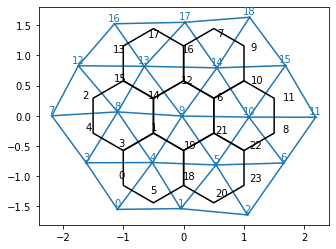

In [ ]:
mesh = get_tri_hemesh(noise=0, nx=5, ny=5)  # 13, 19
mesh.set_voronoi()
for fc in mesh.faces.values():
    fc.rest_shape = sqrt(3)*np.eye(2)
mesh.transform_vertices(lambda x: shear_mat(1.1)@x+np.random.normal(size=2, scale=0.05))
mesh.set_rest_lengths()

# set origin
#mean = np.mean([v.coords for v in mesh.vertices.values()], axis=0)
#mesh.transform_vertices(lambda x: x-mean)

# if one wants one junction to intercalate before all others
#mesh.vertices[17].coords -= np.array([.1, 0])
#mesh.vertices[18].coords += np.array([.1, 0])

mesh.labelplot(halfedge_labels=False)

mesh.cellplot()
mesh.triplot()
plt.gca().set_aspect("equal", adjustable="box")

In [ ]:
## simulate

meshes = []
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

for i in tqdm(range(n_steps)):    
    # euler step
    mesh.euler_step(dt=dt, rhs=excitable_dt_post, params={"k": k, "m": m})
    # flatten triangulation
    mesh.flatten_triangulation()
    # primal optimization
    mesh.optimize_cell_shape(energy_fct_kwargs=cell_shape_args, tol=tol, maxiter=maxiter, verbose=False)
    # check for intercalation
    primal_lengths = mesh.get_primal_edge_lens(oriented=True)
    flipped = []
    for key, val in primal_lengths.items():
        if val < epsilon_l and not any([key in x for x in last_flipped_edges[-forbid_reflip:]]):  
            try:
                print(f"flip {key}, tpt {i}")
                he = mesh.hes[key]
                mesh.flip_edge(key)
                mesh.reset_rest_passive_flip(he)
                f0, f1 = (he.face, he.twin.face)
                f0.dual_coords, f1.dual_coords = rotate_about_center(np.stack([f0.dual_coords, f1.dual_coords]))
                flipped.append(he._heid)
            except ValueError:
                continue
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

last_flipped_edges = last_flipped_edges[1:]
times = np.array(times)[1:]

  0%|          | 0/20 [00:00<?, ?it/s]

[<matplotlib.lines.Line2D>]

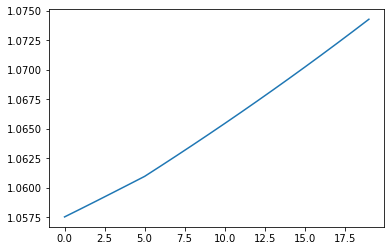

In [ ]:
plt.plot([meshes[t].hes[57].rest for t in range(len(meshes))])
# need to normalize: plt.plot([meshes[t].get_rel_tension()[42] for t in range(150)])

(0.0, 1.7320508075688772)

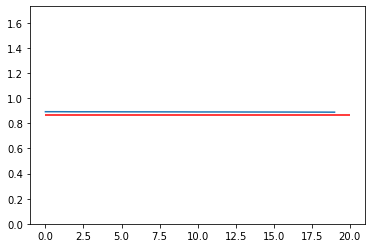

In [ ]:
plt.plot([polygon_area(np.stack([fc.dual_coords for fc in meshes[t].vertices[9].get_face_neighbors()]))
         for t in range(len(meshes))])
plt.hlines(A0, 0, len(meshes), color="r")
plt.ylim([0, sqrt(3)])

# one more possibility: set the A0 anew for each cell, at each iteration. this cannot prevent drift, ofc.

In [ ]:
#| notest
%matplotlib inline

<IPython.core.display.Javascript object>


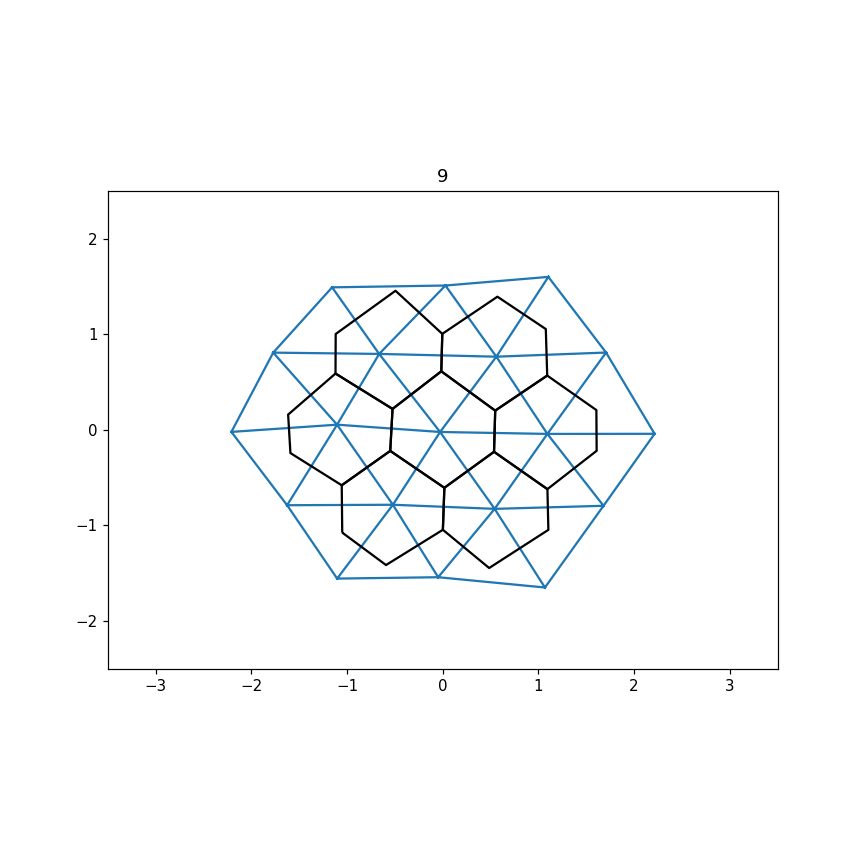

interactive(children=(IntSlider(value=9, description='i', max=18), Output()), _dom_classes=('widget-interact',…

In [ ]:
#| notest
%matplotlib notebook

# Plotting function for slider plot
# using the notebook plot mode gives smoother results. still not completely optimize but whatever
#

fig = plt.figure(figsize=(8,8))
def plot_mesh(i):
    plt.cla()
    plt.xlim([-3.5, 3.5])
    plt.ylim([-2.5, 2.5])
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot()
    meshes[i].triplot()
    plt.title(i)
    for x in last_flipped_edges[i]:
        he = meshes[i].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        plt.plot(*line.T, c="r")
widgets.interact(plot_mesh, i=(0, n_steps-2, 1));

In [ ]:
#| notest
%matplotlib inline

## Now let's also save it als HTML5 animation - can take a bit of time due to inefficiency

# create the figure and axes objects
fig = plt.figure(facecolor="white")
# snimation parameters
nframes, frame_dt = n_steps, 200  # Delay between frames in milliseconds

# function that draws each frame of the animation
def animate_meshes(n):
    plt.cla()
    plt.xlim([-3.5, 3.5])
    plt.ylim([-2.5, 2.5])
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title('Triangle-based shape tensor,\nregularization=per-cell area.')
    meshes[n].cellplot()
    meshes[n].triplot()
    for x in last_flipped_edges[i]:
        he = meshes[i].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        plt.plot(*line.T, c="r")
    if n == nframes-1:
        plt.close()

# run the animation
anim = animation.FuncAnimation(fig, animate_meshes, frames=nframes, interval=frame_dt, repeat=False)
anim.save('plots/cell_shape_animation_regularization_small_new.mp4', fps=4,)
#extra_args=['-vcodec', 'libx264'])